In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
import shap
import pycox
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import pandas as pd

In [8]:
np.random.seed(1234)
_ = torch.manual_seed(123)
print(pycox.__version__)

0.2.2


In [31]:
df_train=pd.read_csv('training_rsf_fin.tsv',sep="\t")
df_train=df_train.rename(columns={"events":"event","TimeInStudy":"duration"})

df_test=pd.read_csv('testing_rsf_fin.tsv',sep="\t")
df_test=df_test.rename(columns={"events":"event","TimeInStudy":"duration"})

In [32]:

df_train["event"]=df_train["event"].astype("float32")
df_test["event"]=df_test["event"].astype("float32")
df_train.head()

,d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Marinifilaceae.g__Butyricimonas,d__Bacteria.p__Firmicutes.c__Clostridia.o__Lachnospirales.f__Lachnospiraceae.g__Lachnospiraceae_ND3007_group,d__Bacteria.p__Firmicutes.c__Negativicutes.o__Veillonellales.Selenomonadales.f__Selenomonadaceae.g__Megamonas,d__Bacteria.p__Firmicutes.c__Clostridia.o__Lachnospirales.f__Lachnospiraceae.g__Lachnospiraceae_UCG.003,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_UCG.014.f__Clostridia_UCG.014.g__Clostridia_UCG.014,d__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__uncultured.g__uncultured,d__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__.Eubacterium._coprostanoligenes_group.g__.Eubacterium._coprostanoligenes_group,d__Bacteria.p__Actinobacteriota.c__Actinobacteria.o__Corynebacteriales.f__Corynebacteriaceae.g__Corynebacterium,d__Bacteria.p__Firmicutes.c__Clostridia.o__Christensenellales.f__Christensenellaceae.g__Christensenella,d__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__Oscillospiraceae.g__Colidextribacter,...,d__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__Oscillospiraceae.g__uncultured,d__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus,d__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__.Clostridium._methylpentosum_group.g__.Clostridium._methylpentosum_group,d__Archaea.p__Euryarchaeota.c__Methanobacteria.o__Methanobacteriales.f__Methanobacteriaceae.g__Methanobrevibacter,age,sex,duration,event,reads,shannon
0,0,1.697411,0,0,0,0,1.229757,0,0,0.000000,...,0,0.285789,0,0,23,1,11.413699,0.0,36719,3.880142
1,0,0.241975,0,0,1,0,0.299792,0,0,0.533202,...,1,0.098503,0,0,25,0,11.153425,0.0,49512,3.302877
2,0,0.708558,0,0,0,0,0.122830,0,0,0.014212,...,1,0.064968,0,0,23,0,11.115068,0.0,102284,2.993594
3,0,0.000000,0,0,1,0,0.000000,0,0,0.247811,...,0,0.019897,0,0,19,1,10.789041,0.0,57052,2.772918
4,0,0.415693,0,0,1,0,2.945877,0,0,0.213389,...,1,0.055426,1,0,29,0,1.654795,0.0,114134,4.483052


In [33]:
cols_standardize = ['age', 'shannon', 'reads']
cols_leave = list(df_train.filter(like='d_', axis=1).columns)
cols_leave.append("sex")
standardize = [([col], StandardScaler()) for col in cols_standardize]

leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [34]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.fit_transform(df_test).astype('float32')

In [37]:
x_train

array([[ 0.6137421 ,  0.36331615, -1.0336689 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.86773074, -1.040564  , -0.59527963, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6137421 , -1.7927223 ,  1.2131058 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5451615 , -0.10989111, -0.0365416 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5292069 ,  0.036791  ,  0.8232742 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6137421 ,  0.30153427,  0.1620066 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [38]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_test = get_target(df_test)
durations_test, events_test = get_target(df_test)
val=x_test, y_test

In [39]:
y_train

(array([11.41369863, 11.15342466, 11.11506849, ...,  2.13424658,
         2.11506849,  1.90136986]),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [40]:
in_features = x_train.shape[1]
n_nodes = 32
num_nodes = [n_nodes,n_nodes]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)


In [41]:
model = CoxPH(net, tt.optim.Adam)

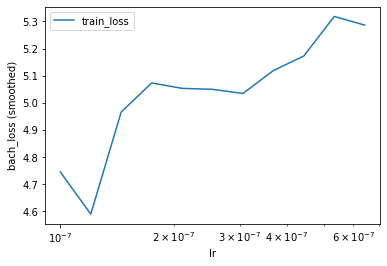

In [42]:
batch_size = 200
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [43]:
lrfinder.get_best_lr()

0.0001

In [44]:
model.optimizer.set_lr(0.0001)

In [45]:
epochs = 1512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [46]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	
9:	[0s / 0s],	
CPU times: user 2.8 s, sys: 0 ns, total: 2.8 s
Wall time: 237 ms


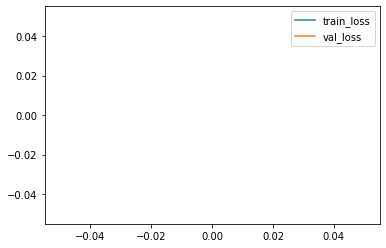

In [47]:
_ = log.plot()

In [48]:
_ = model.compute_baseline_hazards()

In [49]:
surv = model.predict_surv_df(x_test)


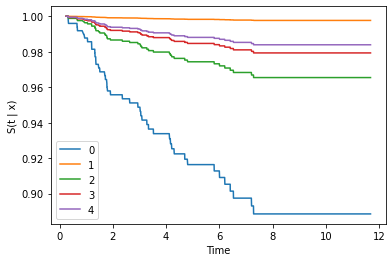

In [50]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [51]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [52]:
ev.concordance_td()

0.5909992069785884

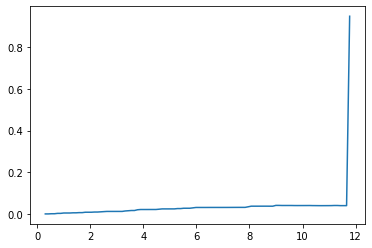

In [53]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [54]:
ev.integrated_brier_score(time_grid)

0.029454429123466387

In [55]:
ev.integrated_nbll(time_grid)

0.13987028685088226